In [1]:
import numpy as np
import pandas as pd
from tqdm import trange
import sklearn.metrics.pairwise as kernel
from copy import copy
import statsmodels.api as sm
import gc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import math
from sklearn.mixture import GaussianMixture



/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import_path_char = "data/cha1.csv"
data_char = pd.read_csv(import_path_char)
data_char = data_char.set_index("date")
date = list(pd.unique(data_char.index))
date.sort()
characteristic_dic = dict(zip(date, [2*data_char.loc[i].set_index("PERMNO").iloc[:,1:].rank()/data_char.loc[i].shape[0]-1 for i in date]
                              ))
ret = data_char.loc[date, ["PERMNO", "RET"]].pivot(columns = "PERMNO").loc[:,'RET']


In [15]:
class IPCA():
    def __init__(self,characteristics,ret, n_freedom = None, kernel_method = None, **kwargs):

        self.n_free = n_freedom
        self.kernel_met = kernel_method
        self.kernel_params = kwargs
        self.date_list=list(characteristics.keys())

        if self.n_free != None:

            data = pd.concat([characteristics[i] for i in self.date_list], axis = 0)

            char_array = data.values

            n_clusters = self.n_free

            kmeans = KMeans(n_clusters = n_clusters)

            kmeans.fit(char_array)

            print("clustering finish")

            self.centers = kmeans.cluster_centers_

            if self.kernel_met == "linear_kernel":

                kernel_use = kernel.linear_kernel
            
            elif self.kernel_met == "polynomial_kernel":

                kernel_use = kernel.polynomial_kernel

            elif self.kernel_met == "rbf_kernel":

                kernel_use = kernel.rbf_kernel

            elif self.kernel_met == "sigmoid_kernel":

                kernel_use = kernel.sigmoid_kernel


            _characteristics = copy(characteristics)

            for i in trange(len(self.date_list)):

                t = self.date_list[i]

                centers = self.centers
                index = _characteristics[t].index
                gram_train = kernel_use(_characteristics[t],centers, **self.kernel_params)
                gram_use = pd.DataFrame(gram_train,index = index, columns = [f"Feature{i}" for i in range(1,n_clusters + 1)])
                characteristics[t] = gram_use

        self.characteristics=copy(characteristics)
        self.ret=copy(ret)
        self.stock_list=list(self.ret.columns)
        self.Nt=dict(zip(
            self.date_list,
            [self.characteristics[i].shape[0] for i in self.date_list]
        ))
        self.chanames=list(self.characteristics[self.date_list[0]].columns)
        self.l=len(self.chanames)
        # self.kernel
        
        # for each t, it l*N_t * N_t * 1
        self.xt=pd.DataFrame(np.nan,index=self.date_list,columns=self.chanames)
        for t in self.date_list:
            self.xt.loc[t]=self.characteristics[t].T.dot(self.ret.loc[t,self.characteristics[t].index])
        # z_t square is l*N_t * N_t*l
        self.zt_square=dict(zip(
            self.date_list,
            [self.characteristics[i].T.dot(self.characteristics[i]) for i in self.date_list]
        ))
        self.error_ls = []
        
        gc.collect()
    
    def fit(self,k,maxT=1000,tol=1e-3):
        self.k=k
        eigvalue,eigvector=np.linalg.eig(self.xt.T.dot(self.xt))
        self.gamma=eigvector[:,:self.k]
        
        def calc_ft(zt_square,xt,gamma):
            gamma_zts=gamma.T.dot(zt_square).dot(gamma)
            if np.linalg.det(gamma_zts)>0:
                ft=np.linalg.inv(gamma_zts).dot(gamma.T).dot(xt)
                return ft
            else:
                pass


        def calc_error(characteristics, date_list, ret, ft, gamma, k):

            total_error = 0

            for t in date_list:

                x = characteristics[t].dot(gamma).dot(ft.loc["1963-01-31"].values.reshape(k,1)).values.squeeze()

                y = ret.loc[t, characteristics[t].index].values

                error = np.linalg.norm(x-y)**2

                total_error = total_error + error

            return total_error






        def calc_denomt(ft,zt_square):
            return np.kron(ft.dot(ft.T),zt_square)

        def calc_numert(ft,xt):
            return np.kron(ft,xt)

        def calc_gamma(ft):
            denom=np.zeros((self.k*self.l,self.k*self.l))
            numer=np.zeros((self.k*self.l,1))
            for t in self.date_list:
                ft_=ft.loc[t].values.reshape(self.k,1)
                if ft.loc[t].sum()!=0:
                    denom=denom+calc_denomt(ft_,self.zt_square[t])
                    numer=numer+calc_numert(ft_,self.xt.loc[t].values.reshape(self.l,1))
            if np.linalg.det(denom)>0:
                gamma=np.linalg.inv(denom).dot(numer)
            else:
                gamma=np.linalg.pinv(denom).dot(numer)
            gamma=gamma.reshape(self.k,self.l).T
            return gamma
        
        for i in trange(maxT):
            self.ft=pd.DataFrame(np.nan,index=self.date_list,columns=['PC'+str(i) for i in range(1,self.k+1)])
            for t in self.date_list:
                self.ft.loc[t]=calc_ft(self.zt_square[t],self.xt.loc[t],self.gamma)

            gamma_=copy(self.gamma)
            self.gamma=calc_gamma(self.ft)

            total_error = calc_error(self.characteristics, self.date_list, self.ret, self.ft, self.gamma, self.k)

            # print(f"The total error after round {i} is :", total_error)

            error=((self.gamma-gamma_)**2).sum()

            self.error_ls.append(total_error)
            if error<=tol:
                break
            # else:
            #     print('round {}, error: {}'.format(i+1,error))

        Chol=np.linalg.cholesky(self.gamma.T.dot(self.gamma)).T
        fcov=self.ft.dropna().T.dot(self.ft.dropna())/self.ft.shape[0]
        eigvalue,Orth=np.linalg.eig(Chol.dot(fcov).dot(Chol.T))
        self.gamma=self.gamma.dot(np.linalg.inv(Chol)).dot(Orth)
        self.ft=self.ft.dot(Chol.T).dot(Orth)
        self.ft.columns=['PC'+str(i) for i in range(1,self.k+1)]
        gc.collect()
        
    def predict(self,zt):
        mu=self.ft.mean(skipna=True).values.reshape(self.k,1)
        return zt.dot(self.gamma).dot(mu)[0]

In [19]:
model_1 = IPCA(characteristics = characteristic_dic,ret = ret, n_freedom = 100, kernel_method = "rbf_kernel", gamma = 0.1 )
model_1.fit(k=5)

clustering finish


 11%|█▏        | 114/1000 [02:55<22:47,  1.54s/it]


KeyboardInterrupt: 

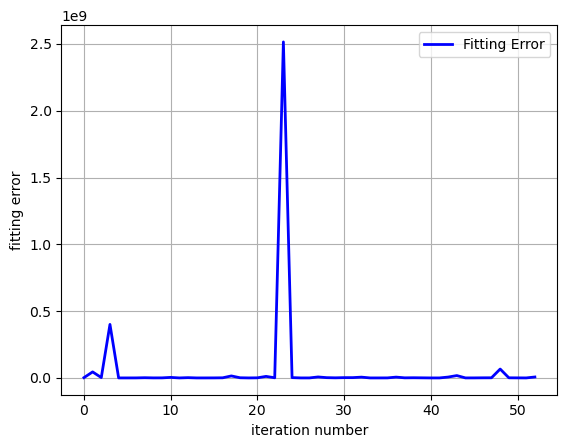

In [20]:
error_ls_1 = [x for x in model_1.error_ls if not math.isnan(x)]
X = np.array(list(range(len(error_ls_1))))
y = np.array(error_ls_1)
plt.figure()
plt.plot(X,y, c = "blue",linewidth = 2, label = "Fitting Error")
plt.legend()
plt.xlabel("iteration number")
plt.ylabel("fitting error")
plt.grid()
plt.show()


In [22]:
error_ls_1

96930.71150016304

In [12]:
model_2 = IPCA(characteristics = characteristic_dic,ret = ret)
model_2.fit(k=5)

 16%|█▌        | 160/1000 [01:12<06:19,  2.21it/s]


KeyboardInterrupt: 

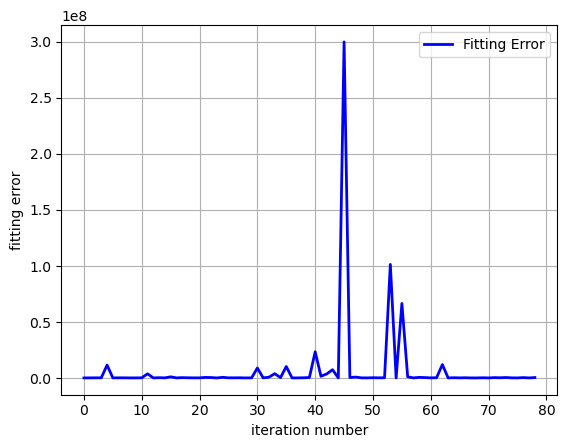

In [13]:
error_ls_2 = [x for x in model_2.error_ls if not math.isnan(x)]
X = np.array(list(range(len(error_ls_2))))
y = np.array(error_ls_2)
plt.figure()
plt.plot(X,y, c = "blue",linewidth = 2, label = "Fitting Error")
plt.legend()
plt.xlabel("iteration number")
plt.ylabel("fitting error")
plt.grid()
plt.show()

In [14]:
error_ls_2

[78068.25291777156,
 120640.11532116869,
 160471.46825088921,
 175142.0557298429,
 11555661.941163968,
 89460.3079755091,
 156682.85467290974,
 162058.29367734565,
 96931.70814668188,
 90090.8934219957,
 176052.54118534387,
 3743013.896606283,
 92191.59800552767,
 279465.01444776985,
 131846.7248912582,
 1051838.8967039012,
 111471.28857545386,
 333640.36509449285,
 204944.62977545903,
 130101.94533311062,
 143405.4309899153,
 538750.8168995309,
 412834.3259146914,
 84231.32984744382,
 613299.7215301141,
 163763.34699590402,
 172893.6114241548,
 192603.6740214189,
 85280.48739274166,
 140032.83086198373,
 8940732.55113168,
 142502.45988083386,
 704262.7375324987,
 3894239.7510236255,
 352577.9762877262,
 10274691.280244533,
 92125.82677587643,
 106727.19419554912,
 214582.59810341834,
 442915.57876195177,
 23438765.188053504,
 1569033.0612495483,
 3628302.1499271914,
 7415137.699618474,
 81445.07480790753,
 299978203.4623235,
 428984.9386135282,
 826402.0056758496,
 150188.86216498882,

In [3]:
ret_dict = dict(zip(date, [ret.loc[i].to_frame() for i in date]
                           ))
for i in date:

    ret_dict[i].columns = ["RET"]

data_dict = {}

for i in date:

    data_dict[i] = characteristic_dic[i].join(ret_dict[i], how = "inner")

data = pd.concat([data_dict[i] for i in date], axis = 0)
stock_ret = data["RET"]
stock_char = data.iloc[:,:-1]

char_array = stock_char.values
ret_array = stock_ret.values
# n_clusters = 20
# kmeans = KMeans(n_clusters = n_clusters)

# kmeans.fit(char_array)
# print("clustering finish")
# centers = kmeans.cluster_centers_
# gamma = 1
# gram_train = kernel.rbf_kernel(char_array, centers, gamma = gamma)

100%|██████████| 36/36 [8:21:47<00:00, 836.31s/it]   


ValueError: x and y must have same first dimension, but have shapes (10,) and (36,)

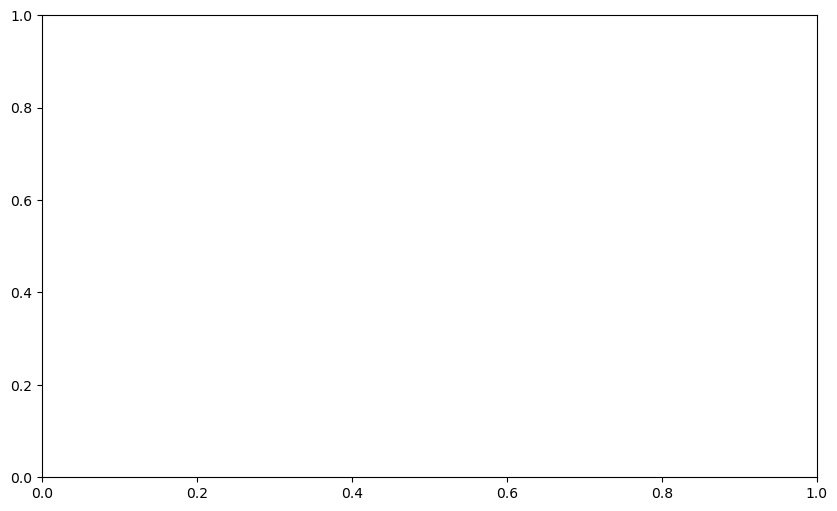

In [4]:
bic_values = []

n_components_range = range(1, 11)

for n_component in trange(1,37):

    gmm = GaussianMixture(n_components = n_component, random_state=42)

    gmm.fit(char_array)

    bic_values.append(gmm.bic(char_array))

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_values, marker='o')
plt.title('BIC scores for different number of components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()

In [5]:
bic_values

[29384954.8748869,
 24096508.246828552,
 20771343.313190233,
 18980524.288587436,
 17516820.32944796,
 16758099.780625716,
 16027831.477815624,
 14795637.675043715,
 13921622.356975043,
 13394719.39086618,
 12836631.655259073,
 12398594.393063892,
 12010169.23633608,
 11545224.102199156,
 11315511.912089424,
 10773231.188632013,
 10514541.631723182,
 10208159.033222442,
 9800896.910235455,
 9531875.635871628,
 9340042.396997174,
 9090131.677420508,
 8872173.395394271,
 8577251.556262206,
 8220144.4464652855,
 8079088.915853887,
 7838678.386318907,
 7902261.096038268,
 7537368.174363605,
 7562684.2337039225,
 7176390.405136511,
 7101632.885333962,
 6916215.05735525,
 6799672.182318227,
 6650917.038559093,
 6626766.064652571]

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

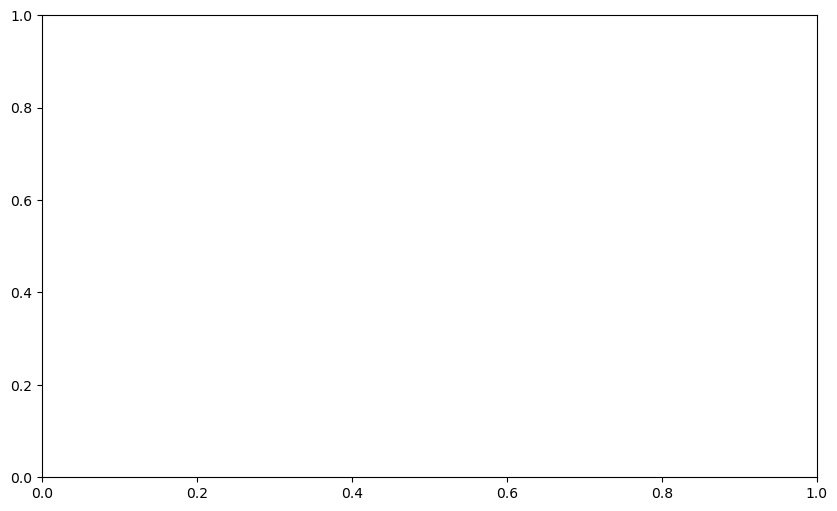

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_values, marker='o')
plt.title('BIC scores for different number of components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()

In [ ]:
data = pd.concat([model.characteristics[i] for i in model.date_list], axis = 0)
data = data.values
indices = np.random.choice(data.shape[0], 10000, replace = True)
sample_data = data[indices]
tsne = TSNE(n_components=2, perplexity=100, n_iter=500, verbose=1)
reduced_data = tsne.fit_transform(sample_data)

In [ ]:
plt.scatter(reduced_data[:,0], reduced_data[:,1], c = "blue", s=1, label = "reduced point")
plt.title("distribution of reduced point")
plt.legend()
plt.show()

In [ ]:
n_clusters = 20
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(reduced_data)

centers = kmeans.cluster_centers_

labels = kmeans.labels_

for i in range(n_clusters):
    plt.scatter(reduced_data[labels == i][:,0], reduced_data[labels == i][:,1], s = 1, label = f"Cluster {i+1}")

plt.scatter(centers[:,0], centers[:,1], c = "red", marker="X", label = "Centers")
plt.title("K-means Clustersing")
# plt.legend()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(char_array, ret_array, test_size=0.25, shuffle= False)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
n_clusters = 50
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(X_train)
centers = kmeans.cluster_centers_

In [ ]:
# Generateing the big gram matrix. 
gamma = 0.1
gram_train = kernel.rbf_kernel(X_train, centers, gamma = gamma)
gram_test = kernel.rbf_kernel(X_test, centers, gamma = gamma)
print(gram_train.shape)
print(gram_test.shape)


In [ ]:
class IPCA():
    def __init__(self,characteristics,ret,n_freedom, kernel_method, **kwargs):
        self.characteristics=copy(characteristics)
        self.ret=copy(ret)
        self.n_free = n_freedom
        self.kernel_met = kernel_method
        self.kernel_params = kwargs
        self.date_list=list(self.characteristics.keys())
        self.stock_list=list(self.ret.columns)
        self.Nt=dict(zip(
            self.date_list,
            [self.characteristics[i].shape[0] for i in self.date_list]
        ))
        self.chanames=list(self.characteristics[self.date_list[0]].columns)
        self.l=len(self.chanames)
        # self.kernel
        
        # for each t, it l*N_t * N_t * 1
        self.xt=pd.DataFrame(np.nan,index=self.date_list,columns=self.chanames)
        for t in self.date_list:
            self.xt.loc[t]=self.characteristics[t].T.dot(self.ret.loc[t,self.characteristics[t].index])
        # z_t square is l*N_t * N_t*l
        self.zt_square=dict(zip(
            self.date_list,
            [self.characteristics[i].T.dot(self.characteristics[i]) for i in self.date_list]
        ))
        
        gc.collect()
    
    def fit(self,k,maxT=1000,tol=1e-3):
        self.k=k
        eigvalue,eigvector=np.linalg.eig(self.xt.T.dot(self.xt))
        self.gamma=eigvector[:,:self.k]
        
        def calc_ft(zt_square,xt,gamma):
            gamma_zts=gamma.T.dot(zt_square).dot(gamma)
            if np.linalg.det(gamma_zts)>0:
                ft=np.linalg.inv(gamma_zts).dot(gamma.T).dot(xt)
                return ft
            else:
                pass

        def calc_denomt(ft,zt_square):
            return np.kron(ft.dot(ft.T),zt_square)

        def calc_numert(ft,xt):
            return np.kron(ft,xt)

        def calc_gamma(ft):
            denom=np.zeros((self.k*self.l,self.k*self.l))
            numer=np.zeros((self.k*self.l,1))
            for t in self.date_list:
                ft_=ft.loc[t].values.reshape(self.k,1)
                if ft.loc[t].sum()!=0:
                    denom=denom+calc_denomt(ft_,self.zt_square[t])
                    numer=numer+calc_numert(ft_,self.xt.loc[t].values.reshape(self.l,1))
            if np.linalg.det(denom)>0:
                gamma=np.linalg.inv(denom).dot(numer)
            else:
                gamma=np.linalg.pinv(denom).dot(numer)
            gamma=gamma.reshape(self.k,self.l).T
            return gamma
        
        for i in range(maxT):
            self.ft=pd.DataFrame(np.nan,index=self.date_list,columns=['PC'+str(i) for i in range(1,self.k+1)])
            for t in self.date_list:
                self.ft.loc[t]=calc_ft(self.zt_square[t],self.xt.loc[t],self.gamma)

            gamma_=copy(self.gamma)
            self.gamma=calc_gamma(self.ft)

            error=((self.gamma-gamma_)**2).sum()
            if error<=tol:
                break
            else:
                print('round {}, error: {}'.format(i+1,error))

        Chol=np.linalg.cholesky(self.gamma.T.dot(self.gamma)).T
        fcov=self.ft.dropna().T.dot(self.ft.dropna())/self.ft.shape[0]
        eigvalue,Orth=np.linalg.eig(Chol.dot(fcov).dot(Chol.T))
        self.gamma=self.gamma.dot(np.linalg.inv(Chol)).dot(Orth)
        self.ft=self.ft.dot(Chol.T).dot(Orth)
        self.ft.columns=['PC'+str(i) for i in range(1,self.k+1)]
        gc.collect()
        
    def predict(self,zt):
        mu=self.ft.mean(skipna=True).values.reshape(self.k,1)
        return zt.dot(self.gamma).dot(mu)[0]

In [ ]:
class FMLARS():
    def __init__(self,characteristics,ret):
        self.characteristics=copy(characteristics)
        self.ret=copy(ret)
        self.T=self.ret.shape[0]
        
        self.date_list=list(self.characteristics.keys())
        self.stock_list=list(self.ret.columns)
        self.Nt=dict(zip(
            self.date_list,
            [self.characteristics[t].shape[0] for t in self.date_list]
        ))
        self.chanames=list(self.characteristics[self.date_list[0]].columns)
        self.l=len(self.chanames)
        
        self.xt=dict(zip(
            self.date_list,
            [
                self.characteristics[t].T.dot(self.ret.loc[t,self.characteristics[t].index]).values.reshape(self.l,1)/self.Nt[t]
                for t in self.date_list
            ]
        ))
        
        self.zt_square=dict(zip(
            self.date_list,
            [self.characteristics[i].T.dot(self.characteristics[i]).values for i in self.date_list]
        ))
        
        gc.collect()
        
    
    def fit(self,phi2,lamb):
        
        def Icrp(Ak,t,lamb):
            icrp=np.zeros((self.l,self.l))
            k=len(Ak)
            try:
                icrp[np.ix_(Ak,Ak)]=np.linalg.inv(self.zt_square[t][np.ix_(Ak,Ak)]+lamb*self.Nt[t]*np.eye(k,k))
            except:
                icrp[np.ix_(Ak,Ak)]=np.linalg.pinv(self.zt_square[t][np.ix_(Ak,Ak)]+lamb*self.Nt[t]*np.eye(k,k))
            return icrp

        def calc_gamma_t(Ak,proding_list,t,lamb):
            gamma_t=self.Nt[t]*Icrp(Ak,t,lamb).dot(proding_list[t]).dot(self.xt[t])
            return gamma_t

        def solve_alpha(coef2,coef1,cons):
            if coef2==0:
                return np.nan
            else:
                x1=(-2*coef1+np.sqrt(4*coef1**2-4*coef2*cons))/(2*coef2)
                x2=(-2*coef1-np.sqrt(4*coef1**2-4*coef2*cons))/(2*coef2)
                if 0<x1<1:
                    return(float(x1))
                else:
                    return(float(x2))

        def calc_NW_tvalue(factor_value):
            tsmod=sm.OLS(endog=factor_value, exog=np.ones(self.T), hasconst=False)\
                .fit(cov_type='HAC',cov_kwds={'maxlags':6})
            return tsmod.tvalues[0]

        self.lamb=lamb
        #k=0
        self.Ak_list=[]
        self.alpha_list=[]
        self.Ak_list.append(pd.DataFrame(
                    sum([(self.Nt[t]*self.xt[t])**2 for t in self.date_list])\
                    +phi2*sum([self.Nt[t]*self.xt[t] for t in self.date_list])**2
                ).idxmax().iloc[0])

        proding_list=dict(zip(
            self.date_list,
            [np.eye(self.l) for t in self.date_list]
        ))
        
        #k>0
        print('Estimating FM-LARS')
        for k in trange(self.l):
            try:
                Zr=[]
                Zsq_gamma=[]
                Ak=self.Ak_list[0:k+1]
                Ak_1=self.Ak_list[0:k]
                for t in self.date_list:
                    if k>0:
                        proding_list[t]=proding_list[t]\
                        .dot(np.eye(self.l)-self.alpha_list[k-1]*self.zt_square[t].dot(Icrp(Ak_1,t,self.lamb)))
                gamma_t_list=dict(zip(
                    self.date_list,
                    [calc_gamma_t(Ak,proding_list,t,self.lamb) for t in self.date_list]
                ))
                
                for t in self.date_list:
                    Zr.append(self.Nt[t]*proding_list[t].dot(self.xt[t]))
                    Zsq_gamma.append(self.zt_square[t].dot(gamma_t_list[t]))

                coef2=sum([Zg**2 for Zg in Zsq_gamma])\
                        +phi2*sum(Zsq_gamma)**2
                coef2=coef2-coef2[self.Ak_list[0]]
                coef1=-sum([zr * Zg for (zr,Zg) in zip(Zr,Zsq_gamma)])\
                        -phi2*sum(Zr)*sum(Zsq_gamma)                
                coef1=coef1-coef1[self.Ak_list[0]]
                cons=sum([zr**2 for zr in Zr])+phi2*sum(Zr)**2                
                cons=cons-cons[self.Ak_list[0]]
                
                
                solving_alpha_list=np.array([solve_alpha(c2,c1,c) for (c2,c1,c) in zip(coef2,coef1,cons)])
                solving_alpha_list[Ak]=np.nan

                if k<self.l-1:
                    j_=pd.DataFrame(solving_alpha_list).idxmin().iloc[0]
                    alpha_k=solving_alpha_list[j_]
                else:
                    j_=Ak[len(Ak)-1]
                    alpha_k=1
                self.Ak_list.append(j_)
                self.alpha_list.append(alpha_k)
                
                factor_k=pd.DataFrame(np.nan,index=self.date_list,columns=self.chanames)
                for t in self.date_list:
                    factor_k.loc[t]=gamma_t_list[t].reshape(self.l,)
                if k==0:
                    self.factor_list=[self.alpha_list[k]*factor_k]
                else:
                    self.factor_list.append(self.factor_list[k-1]+self.alpha_list[k]*factor_k)
            except:
                break
        
        self.maxk=len(self.factor_list)
        
        def get_mu_hat(k):
            mu_hat=pd.DataFrame(zip(\
                    [np.mean(self.factor_list[k].iloc[:,i]) for i in range(self.l)],\
                    [calc_NW_tvalue(self.factor_list[k].iloc[:,i]) for i in range(self.l)]
                        ),columns=['risk premium','t value'],\
                       index=self.chanames).fillna(0)
            mu_hat=mu_hat[mu_hat.iloc[:,1]!=0]
            return(mu_hat)
        
        self.mu_hat=[get_mu_hat(k) for k in range(self.maxk)]
                
    def predict(self,Z_t,maxk=None):
        if maxk==None:
            maxk=self.maxk
        prediction=[]
        for k in range(maxk):
            r_hat=Z_t.loc[:,self.mu_hat[k].index].dot(self.mu_hat[k].iloc[:,0].values)
            prediction.append(r_hat)
        return prediction